Using device: cuda
--- Generating Training Data ---
Training parameters (p): [3.55   3.5939 3.7    3.8061 3.85   3.8061 3.7    3.5939 3.55   3.5939
 3.7    3.8061 3.85   3.8061 3.7    3.5939 3.55   3.5939 3.7    3.8061]
Training range: [3.550, 3.850]
Generating training data for p = 3.5500...
Generating training data for p = 3.5939...
Generating training data for p = 3.7000...
Generating training data for p = 3.8061...
Generating training data for p = 3.8500...
Generating training data for p = 3.8061...
Generating training data for p = 3.7000...
Generating training data for p = 3.5939...
Generating training data for p = 3.5500...
Generating training data for p = 3.5939...
Generating training data for p = 3.7000...
Generating training data for p = 3.8061...
Generating training data for p = 3.8500...
Generating training data for p = 3.8061...
Generating training data for p = 3.7000...
Generating training data for p = 3.5939...
Generating training data for p = 3.5500...
Generating trainin

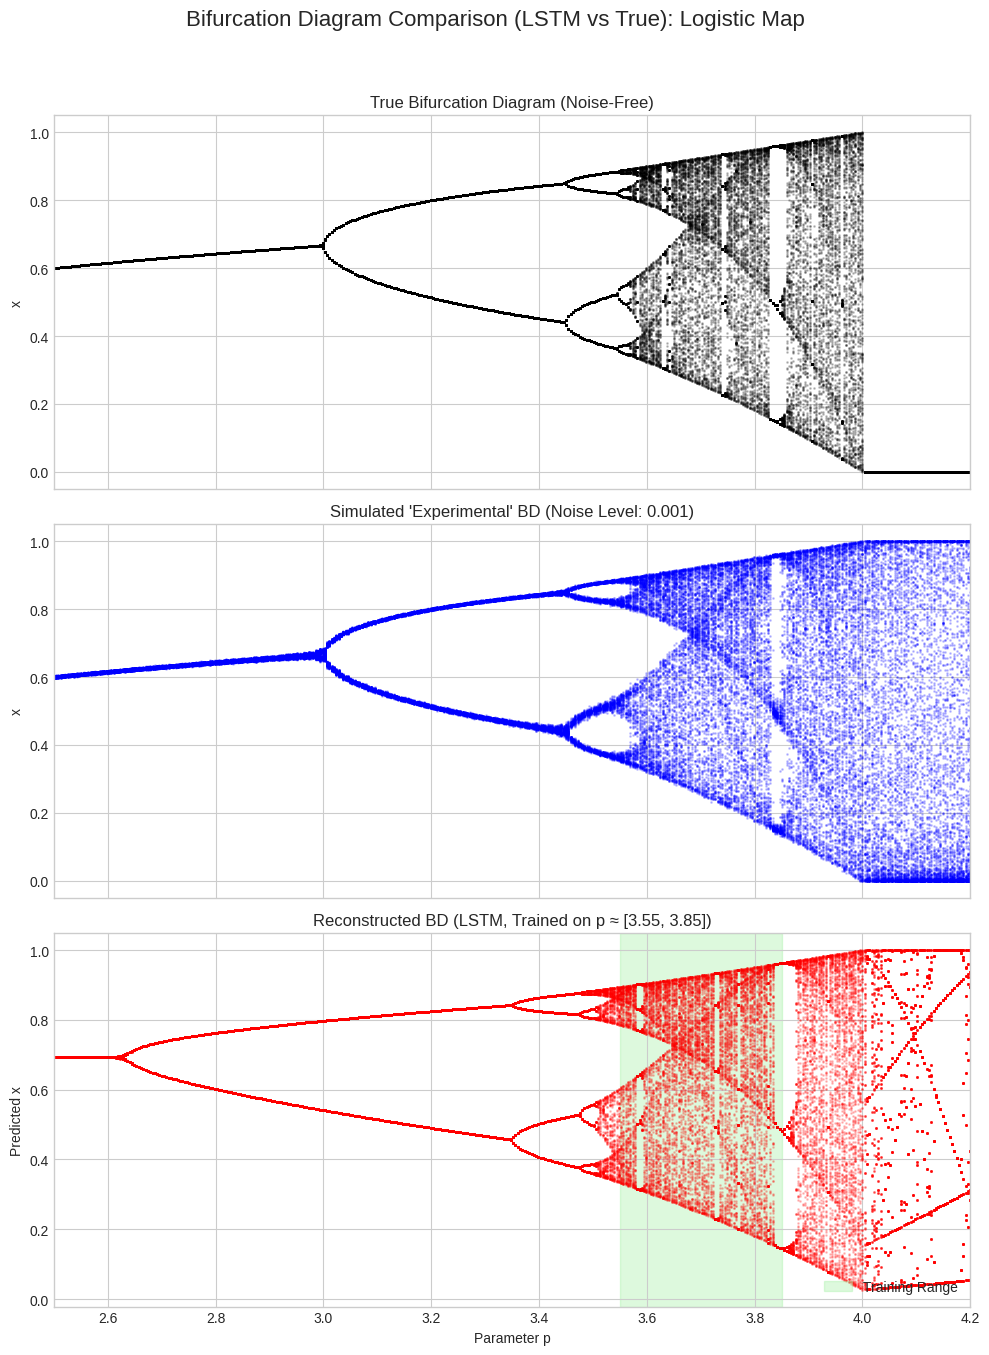

Reconstruction loop finished.
Reconstruction loop finished.


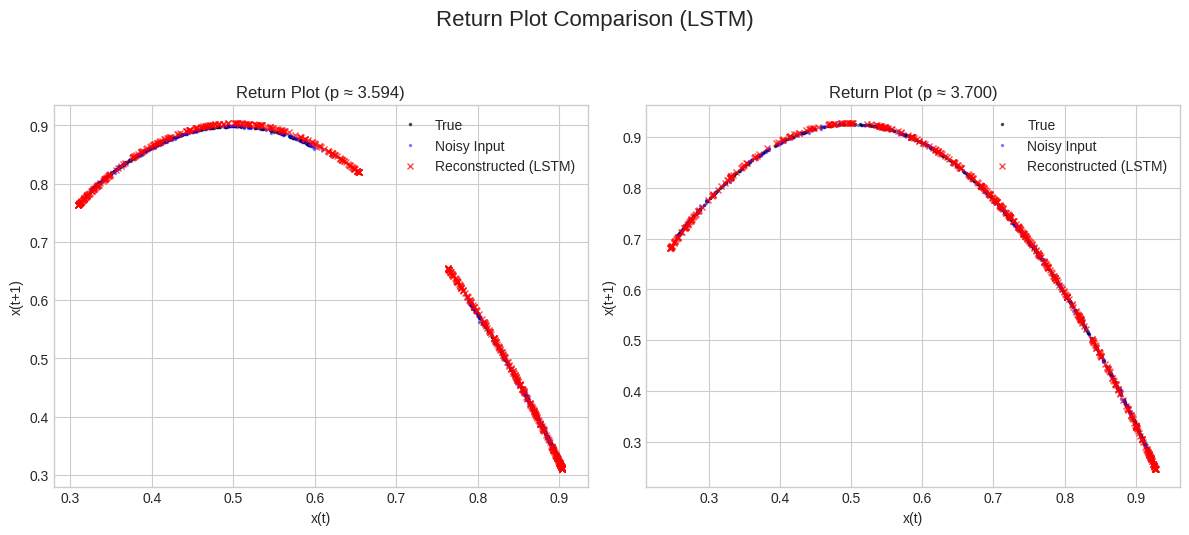

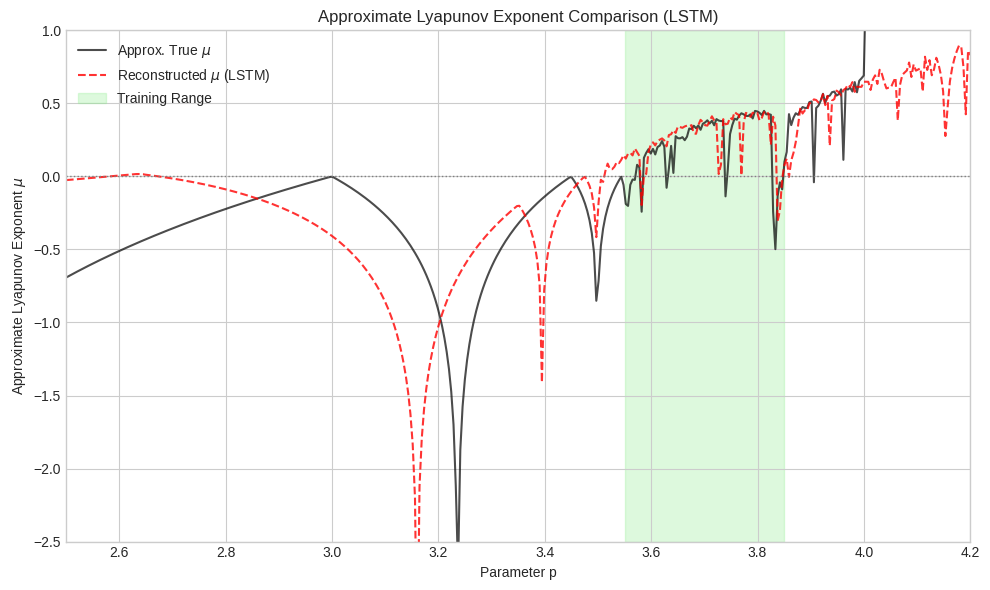


--- End of Simulation ---


In [6]:
# -*- coding: utf-8 -*-
"""
Bifurcation Diagram Reconstruction using LSTM

Adapts the task from the ELM+PCA approach to use a Long Short-Term Memory (LSTM)
network. Trains a single LSTM to predict x(t+1) given x(t) and parameter p.

Note: This method differs from the ELM+PCA approach in Itoh et al. (2020) [2].
It does not use PCA on model weights for parameterization.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
import time

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Data Generation: Logistic Map with Noise ---
def generate_logistic_series(p, x0=0.5, length=1000, transient=500, noise_level=0.0):
    """
    Generates a time series for the logistic map x(t+1) = p*x(t)*(1-x(t)).
    Includes options for dynamical and observational noise.
    """
    x = np.zeros(length + transient)
    x[0] = np.clip(x0, 0, 1) # Ensure initial condition is valid
    for t in range(1, length + transient):
        # Calculate next state
        next_x = p * x[t-1] * (1 - x[t-1])
        # Add dynamical noise (applied before clipping)
        if noise_level > 0:
             next_x += np.random.normal(0, noise_level)
        # Clip to prevent divergence/invalid values
        x[t] = np.clip(next_x, 0, 1)

    series = x[transient:]
    # Add observational noise
    if noise_level > 0:
        series += np.random.normal(0, noise_level, len(series))
    # Final check for NaNs/Infs and clip again if noise pushes outside [0,1]
    series = np.nan_to_num(series, nan=0.5, posinf=1.0, neginf=0.0) # Replace NaN/Inf safely
    series = np.clip(series, 0, 1)
    return series

# --- 2. LSTM Model Definition ---
class LSTMPredictor(nn.Module):
    def __init__(self, input_size=2, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM layer: input_size includes x(t) and parameter p
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer to map LSTM output to prediction
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, p_val):
        # x shape: (batch_size, seq_len, 1) for state
        # p_val shape: (batch_size, seq_len, 1) for parameter
        
        # Concatenate state and parameter along the feature dimension
        combined_input = torch.cat((x, p_val), dim=2) # Shape: (batch_size, seq_len, 2)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, combined_input.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, combined_input.size(0), self.hidden_size).to(device)

        # Pass through LSTM
        out, _ = self.lstm(combined_input, (h0, c0)) # out shape: (batch_size, seq_len, hidden_size)

        # Pass the output of the last time step through the fully connected layer
        out = self.fc(out[:, -1, :]) # Use only the last output for prediction, shape: (batch_size, output_size)
        return out

# --- 3. Training Function ---
def train_lstm(model, dataloader, criterion, optimizer, num_epochs):
    print("Starting LSTM Training...")
    model.train() # Set model to training mode
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (inputs_x, inputs_p, targets) in enumerate(dataloader):
            inputs_x = inputs_x.to(device) # Shape: (batch_size, seq_len, 1)
            inputs_p = inputs_p.to(device) # Shape: (batch_size, seq_len, 1)
            targets = targets.to(device)   # Shape: (batch_size, 1)

            # Forward pass
            outputs = model(inputs_x, inputs_p)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        if (epoch + 1) % 10 == 0 or epoch == 0:
             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}')

    end_time = time.time()
    print(f"Training finished in {end_time - start_time:.2f} seconds.")
    return model

# --- 4. Data Preparation for LSTM ---
def prepare_lstm_data(all_series_data, p_values, sequence_length=1):
    """Prepares data for LSTM training with parameter p as input."""
    sequences_x = []
    sequences_p = []
    targets_y = []

    for p in p_values:
        series = all_series_data[p]
        if len(series) <= sequence_length:
            continue # Skip if series is too short

        # Create sequences of [x(t)] and [p] as input, x(t+1) as target
        for i in range(len(series) - sequence_length):
            seq_x = series[i : i + sequence_length]
            seq_p = np.full(sequence_length, p) # Repeat p for the sequence length
            target = series[i + sequence_length]

            sequences_x.append(seq_x)
            sequences_p.append(seq_p)
            targets_y.append(target)

    # Convert to numpy arrays
    sequences_x = np.array(sequences_x)
    sequences_p = np.array(sequences_p)
    targets_y = np.array(targets_y)

    # Reshape for LSTM: (num_samples, seq_len, num_features)
    # Features for x is 1, features for p is 1
    sequences_x = sequences_x.reshape(-1, sequence_length, 1)
    sequences_p = sequences_p.reshape(-1, sequence_length, 1)
    targets_y = targets_y.reshape(-1, 1) # Target is single value

    # Convert to PyTorch tensors
    sequences_x_tensor = torch.tensor(sequences_x, dtype=torch.float32)
    sequences_p_tensor = torch.tensor(sequences_p, dtype=torch.float32)
    targets_y_tensor = torch.tensor(targets_y, dtype=torch.float32)

    return TensorDataset(sequences_x_tensor, sequences_p_tensor, targets_y_tensor)


# --- 5. Simulation Parameters ---
# Training Range Parameters
N_PARAMS_TRAIN = 20
p_values_train = np.array([-0.15 * np.cos(2 * np.pi * (n - 1) / 8) + 3.7 for n in range(1, N_PARAMS_TRAIN + 1)])
TRAIN_RANGE = (p_values_train.min(), p_values_train.max())
# Define training parameters uniformly between 3.0 and 4.0
# TRAIN_RANGE = (3.2, 3.7)
# p_values_train = np.linspace(TRAIN_RANGE[0], TRAIN_RANGE[1], N_PARAMS_TRAIN)
# Extended Range for Reconstruction
EXTENDED_RANGE = (2.5, 4.2)
p_range_extended = np.linspace(EXTENDED_RANGE[0], EXTENDED_RANGE[1], 400)

# LSTM Hyperparameters
INPUT_SIZE = 2       # x(t) and p
HIDDEN_SIZE = 32     # Number of LSTM units
NUM_LAYERS = 1
OUTPUT_SIZE = 1      # Predicting x(t+1)
SEQUENCE_LENGTH = 1  # Use only the previous time step x(t) to predict x(t+1)
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 64

# Data Generation Parameters
NOISE_LEVEL = 0.001 # Noise added to data generation
DATA_LENGTH = 1500
TRANSIENT = 500

# Reconstruction Parameters
PRED_WARMUP = 300   # Steps to discard before collecting points
PRED_POINTS = 200   # Number of attractor points to collect per parameter

# --- 6. Generate Training Data ---
print("--- Generating Training Data ---")
print(f"Training parameters (p): {np.round(p_values_train, 4)}")
print(f"Training range: [{TRAIN_RANGE[0]:.3f}, {TRAIN_RANGE[1]:.3f}]")

all_series_train = {}
for p in p_values_train:
    print(f"Generating training data for p = {p:.4f}...")
    x_noisy = generate_logistic_series(p, length=DATA_LENGTH, transient=TRANSIENT, noise_level=NOISE_LEVEL)
    all_series_train[p] = x_noisy

# --- 7. Prepare DataLoaders ---
print("\n--- Preparing Data for LSTM ---")
train_dataset = prepare_lstm_data(all_series_train, p_values_train, sequence_length=SEQUENCE_LENGTH)
if len(train_dataset) == 0:
     raise ValueError("No valid training sequences generated. Check data length and sequence length.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Total training samples (sequences): {len(train_dataset)}")

# --- 8. Initialize and Train LSTM Model ---
print("\n--- Training LSTM Model ---")
lstm_model = LSTMPredictor(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=OUTPUT_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

# Train the model
lstm_model = train_lstm(lstm_model, train_loader, criterion, optimizer, NUM_EPOCHS)

# --- 9. Bifurcation Diagram Reconstruction with LSTM ---
print("\n--- Reconstruction Phase (LSTM) ---")

def reconstruct_bifurcation_lstm(model, p_values, n_predict_points=PRED_POINTS, n_discard_transient=PRED_WARMUP, seq_len=SEQUENCE_LENGTH):
    """
    Reconstructs the bifurcation diagram using the trained LSTM autonomously.
    The parameter 'p' is provided as input to the model at each step.
    """
    model.eval() # Set model to evaluation mode
    all_p_recon = []
    all_x_recon = []

    with torch.no_grad(): # Disable gradient calculation for prediction
        for p in p_values:
            # print(f"Reconstructing for p = {p:.4f}...") # Can be verbose
            x_pred_segment = []
            
            # Initialize sequence with random start or fixed start
            current_sequence_x = torch.rand(1, seq_len, 1).to(device) * 0.5 + 0.25 # Start near middle
            
            # Prepare parameter tensor (constant for this p)
            p_tensor = torch.full((1, seq_len, 1), p, dtype=torch.float32).to(device)

            # Autonomous prediction loop
            for t in range(n_discard_transient + n_predict_points):
                # Predict the next step
                # Input shapes: (batch=1, seq_len, features=1)
                next_x_pred_tensor = model(current_sequence_x, p_tensor) # Output shape: (1, 1)
                
                # Get the scalar prediction value and clip
                next_x_pred = next_x_pred_tensor.item()
                current_x = np.clip(next_x_pred, 0, 1) # Clip prediction
                
                # Update the sequence for the next prediction step
                # Shift sequence left and add new prediction at the end
                new_x_tensor = torch.tensor([[[current_x]]], dtype=torch.float32).to(device)
                if seq_len > 1:
                     current_sequence_x = torch.cat((current_sequence_x[:, 1:, :], new_x_tensor), dim=1)
                else:
                     current_sequence_x = new_x_tensor # Replace if seq_len is 1

                # Store points after discard phase
                if t >= n_discard_transient:
                    x_pred_segment.append(current_x)

            all_p_recon.extend([p] * len(x_pred_segment))
            all_x_recon.extend(x_pred_segment)

    print("Reconstruction loop finished.")
    if not all_p_recon:
         print("Warning: Reconstruction produced no points.")
         return np.array([]), np.array([])

    return np.array(all_p_recon), np.array(all_x_recon)

# Reconstruct over the extended range using the trained LSTM
p_recon, x_recon = reconstruct_bifurcation_lstm(lstm_model, p_range_extended)

# --- 10. Generate True and Noisy Bifurcation Diagrams for Comparison ---
# (Same as before)
print("\nGenerating comparison diagrams...")
def generate_bd_points(p_values, length=PRED_POINTS, transient=TRANSIENT, noise=0.0):
    """Generates points for a bifurcation diagram."""
    all_p = []
    all_x = []
    for p in p_values:
        x_series = generate_logistic_series(p, x0=0.5, length=length, transient=transient, noise_level=noise)
        all_p.extend([p] * len(x_series))
        all_x.extend(x_series)
    return np.array(all_p), np.array(all_x)

p_true, x_true = generate_bd_points(p_range_extended, noise=0.0)
p_noisy, x_noisy_bd = generate_bd_points(p_range_extended, noise=NOISE_LEVEL)

# --- 11. Calculate Approximate Lyapunov Exponent ---
# Using the same approximation based on the logistic map derivative
# A more accurate method would involve calculating the Jacobian of the LSTM,
# which is complex. This approximation assumes the LSTM learned the map well.
def approx_lyapunov_exponent(p_vals, x_vals):
    """Approximates Lyapunov exponent using logistic map derivative on attractor points."""
    lyap_exps = {}
    for p, x in zip(p_vals, x_vals):
        if p not in lyap_exps:
            lyap_exps[p] = []
        deriv = p * (1.0 - 2.0 * x)
        if abs(deriv) > 1e-9:
             lyap_exps[p].append(np.log(np.abs(deriv)))
    
    unique_p = sorted(lyap_exps.keys())
    mean_lyap = []
    for p in unique_p:
        if lyap_exps[p]:
             mean_lyap.append(np.mean(lyap_exps[p]))
        else:
             mean_lyap.append(np.nan)

    mean_lyap = np.nan_to_num(np.array(mean_lyap), nan=-1.0)
    return np.array(unique_p), mean_lyap

# Calculate Lyapunov for reconstructed and true diagrams
if p_recon.size > 0:
    p_lyap_recon, mu_recon = approx_lyapunov_exponent(p_recon, x_recon)
else:
    p_lyap_recon, mu_recon = np.array([]), np.array([])

p_lyap_true, mu_true = approx_lyapunov_exponent(p_true, x_true)


# --- 12. Visualizations ---
print("\nGenerating plots...")
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    print("Seaborn style not found, using default.")
    pass

# Figure 1: Bifurcation Diagrams Comparison
fig1, axs1 = plt.subplots(3, 1, figsize=(10, 14), sharex=True)
marker_size = 1.0
alpha_val = 0.2

# (a) True Bifurcation Diagram
axs1[0].scatter(p_true, x_true, s=marker_size, c='black', alpha=alpha_val)
axs1[0].set_title(f"True Bifurcation Diagram (Noise-Free)")
axs1[0].set_ylabel("x")
axs1[0].grid(True)

# (b) Noisy Bifurcation Diagram (used for training)
axs1[1].scatter(p_noisy, x_noisy_bd, s=marker_size, c='blue', alpha=alpha_val)
axs1[1].set_title(f"Simulated 'Experimental' BD (Noise Level: {NOISE_LEVEL})")
axs1[1].set_ylabel("x")
axs1[1].grid(True)

# (c) Reconstructed Bifurcation Diagram (LSTM)
if p_recon.size > 0:
    axs1[2].scatter(p_recon, x_recon, s=marker_size, c='red', alpha=alpha_val)
else:
    axs1[2].text(0.5, 0.5, "Reconstruction failed", ha='center', va='center', transform=axs1[2].transAxes)
axs1[2].axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.3, zorder=-1, label='Training Range')
axs1[2].set_title(f"Reconstructed BD (LSTM, Trained on p ≈ [{TRAIN_RANGE[0]:.2f}, {TRAIN_RANGE[1]:.2f}])")
axs1[2].set_xlabel("Parameter p")
axs1[2].set_ylabel("Predicted x")
axs1[2].legend(loc='lower right')
axs1[2].set_xlim(EXTENDED_RANGE)
axs1[2].grid(True)

fig1.suptitle("Bifurcation Diagram Comparison (LSTM vs True): Logistic Map", fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


# Figure 2: Return Plots Comparison
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5.5))
p_periodic = p_values_train[1] # ~3.55
p_chaotic = p_values_train[-2] # ~3.85
# p_periodic = p_range_extended[200]
# p_chaotic = p_range_extended[300]

if p_periodic not in all_series_train or p_chaotic not in all_series_train:
    print("Warning: Data for selected return plot parameters not available in training data.")
else:
    # True data
    x_true_p = generate_logistic_series(p_periodic, length=500, transient=TRANSIENT, noise_level=0.0)
    x_true_c = generate_logistic_series(p_chaotic, length=500, transient=TRANSIENT, noise_level=0.0)
    
    # Noisy input data
    x_noisy_p = all_series_train[p_periodic][-500:]
    x_noisy_c = all_series_train[p_chaotic][-500:]

    # Generate reconstructed data points using LSTM
    _, x_recon_p_full = reconstruct_bifurcation_lstm(lstm_model, np.array([p_periodic]), n_predict_points=500, n_discard_transient=100)
    _, x_recon_c_full = reconstruct_bifurcation_lstm(lstm_model, np.array([p_chaotic]), n_predict_points=500, n_discard_transient=100)

    # Plotting
    if len(x_true_p) > 1:
        axs2[0].plot(x_true_p[:-1], x_true_p[1:], 'k.', markersize=3, alpha=0.6, label='True')
        axs2[0].plot(x_noisy_p[:-1], x_noisy_p[1:], 'b.', markersize=3, alpha=0.4, label=f'Noisy Input')
        if len(x_recon_p_full) > 1:
             axs2[0].plot(x_recon_p_full[:-1], x_recon_p_full[1:], 'rx', markersize=4, alpha=0.7, label='Reconstructed (LSTM)')
        axs2[0].set_title(f"Return Plot (p ≈ {p_periodic:.3f})")
        axs2[0].set_xlabel("x(t)")
        axs2[0].set_ylabel("x(t+1)")
        axs2[0].legend()
        axs2[0].grid(True)
    else:
        axs2[0].text(0.5, 0.5, f"No data for p={p_periodic:.3f}", ha='center', va='center', transform=axs2[0].transAxes)

    if len(x_true_c) > 1:
        axs2[1].plot(x_true_c[:-1], x_true_c[1:], 'k.', markersize=3, alpha=0.6, label='True')
        axs2[1].plot(x_noisy_c[:-1], x_noisy_c[1:], 'b.', markersize=3, alpha=0.4, label=f'Noisy Input')
        if len(x_recon_c_full) > 1:
            axs2[1].plot(x_recon_c_full[:-1], x_recon_c_full[1:], 'rx', markersize=4, alpha=0.7, label='Reconstructed (LSTM)')
        axs2[1].set_title(f"Return Plot (p ≈ {p_chaotic:.3f})")
        axs2[1].set_xlabel("x(t)")
        axs2[1].set_ylabel("x(t+1)")
        axs2[1].legend()
        axs2[1].grid(True)
    else:
         axs2[1].text(0.5, 0.5, f"No data for p={p_chaotic:.3f}", ha='center', va='center', transform=axs2[1].transAxes)

    fig2.suptitle("Return Plot Comparison (LSTM)", fontsize=16, y=0.995)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Figure 3: Lyapunov Exponent Comparison
fig3, ax3 = plt.subplots(figsize=(10, 6))

if p_lyap_true.size > 0:
    ax3.plot(p_lyap_true, mu_true, 'k-', lw=1.5, alpha=0.7, label='Approx. True $\mu$')
if p_lyap_recon.size > 0:
    ax3.plot(p_lyap_recon, mu_recon, 'r--', lw=1.5, alpha=0.8, label='Reconstructed $\mu$ (LSTM)')
else:
    ax3.text(0.5, 0.5, "Lyapunov reconstruction failed", ha='center', va='center', transform=ax3.transAxes)

ax3.axhline(0, color='gray', linestyle=':', linewidth=1)
ax3.axvspan(TRAIN_RANGE[0], TRAIN_RANGE[1], color='lightgreen', alpha=0.3, zorder=-1, label='Training Range')

ax3.set_title("Approximate Lyapunov Exponent Comparison (LSTM)")
ax3.set_xlabel("Parameter p")
ax3.set_ylabel("Approximate Lyapunov Exponent $\mu$")
ax3.set_ylim(-2.5, 1)
ax3.set_xlim(EXTENDED_RANGE)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

print("\n--- End of Simulation ---")

